In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import os
import re
import cv2
import sys
import pickle
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input, Dense, Dropout, GRU, Embedding 
from tensorflow.keras.layers import add, concatenate, TimeDistributed, BatchNormalization
from tensorflow.keras.layers import Activation, RepeatVector, Permute, Lambda, multiply, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from matplotlib import pyplot as plt

#### Parameter Setting

In [2]:
import cocoa                    # Load the dataset access utility
CV2_read_img = True             # Use CV2 Read image or PIL read image
RGB_EQ = True                   # RGB values balance in normalization
img_size = (224, 224)           # Pre-assign the image size
VGG16_img_pp = True             # Use default VGG16 img processing function 
Load_CNN = True
Hidden_NN_enable = True         # Enable NN for Hidden Layer
RNN_training = True             # Re-Train the RNN or use pre-trained model
RNN_batch_size = 1024           # Assign the batch size for the RNN
RNN_cont_train = False          # Continue training based on previouse traind model
RNN_dropout = True              # Enable inter-layer dropout in RNN model 
RNN_epochs = 20                  # RNN training epochs
Chinese_caption = True          # Train with Chinese Captions
Seg_CWords=False               # Performa Chinese word segment for captions
Caption_pre_select = True       # Pre-select caption for training set 
K_fold_caption = False          # Enable K-fold of all captions for training 
Plot_RNN_model = False           # Plot the RNN model
Decoder_NN = False              # Enable NN and transfer value on output decoder (False)  
Glove_enable = False            # Glove Pretrained Word Embedding
Self_attention = True           # Self-Attention 
Bleu_Score = False              # Display the Bleu score with the default caption.
Translate = False               # Display the caption in Chinese.
Recipe_DS = True                # Add the Recipe Dataset
COCO_DS = False
Long_recipe_cap = False

In [3]:
# cocoa.set_data_dir("datasets/pixnet01/coco_2017")

cocoa.set_data_dir("../coco_2017")    # RAW Data Location
if VGG16_img_pp:                                    # Cache file for the image
    cocoa.cache_dir = "cache_vgg16_p"
else:
    cocoa.cache_dir = "cache_vgg16_b"

if Recipe_DS:
    recipe_dir = "../at081-group40/recipes_dataset"
    recipe_image_dir = "../at081-group40/recipes_dataset/images"
    recipe_caption_tmp = "RC_cap_CUT2.csv"

if Chinese_caption:
    check_point_file = "checkpoint003c.keras"       # RNN model checkpoint.
    Chinese_caption_tmp = "C_Caption_CUT.csv"
else:                                               #   for Chinese captions.
    check_point_file = "checkpoint001b.keras"       # RNN model checkpoint 
                                                    #   for English captions.

#### Image loading and Preprocessing

In [4]:
if COCO_DS:                # Load the COCO dataset
    _, f_names_train, caps_train = cocoa.load_records(train=True)  # Load file names and captions in training set             
    _, f_names_val, caps_val = cocoa.load_records(train=False)     # Load file names and captions in validation set      
    num_images_train = len(f_names_train)                          # Total images in trainning set.
    print ('Total:', num_images_train, 'images loaded.') 

In [5]:
if Recipe_DS:                # Load recipe dataset
    RDF = pd.read_csv(os.path.join(recipe_dir ,"image_recipe.csv")).loc[:,'category':'image_name']
    print ('Recipe dataset loaded with shape:',RDF.shape)
    print (RDF.head(3))

Recipe dataset loaded with shape: (74044, 5)
  category   recipes_title                                recipes_description  \
0      眷村菜         眷村懷舊搶鍋麵  以前常在眷村麵店吃到搶鍋麵，融合雞蛋香及肉絲，還有爽Q彈牙的麵條真是美味~😀\n\n使用蕃茄...   
1      眷村菜   [椒麻豆乾]眷村口味涼拌菜                                                NaN   
2      眷村菜  壓力鍋快速《滷牛腱》眷村小菜                                     湯汁可以留下來滷各種滷味喔！   

                                  recipes_ingredient            image_name  
0  食材：手工麵、雞蛋、醬油、豬肉絲、太白粉、鹽、牛蕃茄、米酒、烏醋、蔥、蒜頭、香油、乾香菇、雞...  1fd06f4b7ac2640d.jpg  
1                    食材：豆乾、青蔥、蒜頭、紅辣椒、花椒粉、辣椒油、香油、醬油、糖  1d39b4b33a59fc47.jpg  
2           食材：牛腱子、滷包、辣豆瓣醬、蔥薑蒜（3支六片四瓣）、蠔油、醬油、冰糖、米酒、水  7d109832043a81a5.jpg  


In [6]:
# Build the index database for the valid image+caption 
if Recipe_DS:
    IMG_SET = [ f for f in os.listdir(recipe_image_dir) ]
    print ('Found {} images in recipe dataset.'.format( len(IMG_SET)))

Found 62501 images in recipe dataset.


In [7]:
%%time
if Recipe_DS:
    PC = os.path.join(cocoa.cache_dir, "RC_caps.csv") 
    PM = os.path.join(cocoa.cache_dir, "RC_imgs.csv")
    if os.path.isfile(PC) and os.path.isfile(PM):
        RC_caps = [t[0] for t in pd.read_csv(PC).values.tolist()]
        RC_imgs = [i[0] for i in pd.read_csv(PM).values.tolist()]
    else:    
        RC_caps, RC_imgs =[], []
        for i in tqdm(range(RDF.shape[0])):
            M = RDF.image_name[i]
            T = RDF.recipes_title[i]
            D = RDF.recipes_description[i]
            if M in IMG_SET:
                P = os.path.join(recipe_image_dir, M)
                if os.path.getsize(P) > 2048:
                    RC_imgs.append(M)
                    if Long_recipe_cap:
                        D = '' if pd.isna(D) else (' '+D)
                        RC_caps.append("一盤" + T + D)
                    else:
                        RC_caps.append(T)
        pd.DataFrame(RC_caps).to_csv(PC, index = False)
        pd.DataFrame(RC_imgs).to_csv(PM, index = False)
    num_images_rc = len(RC_caps)
    print ('Got {} samples, lost {} samples'.format(num_images_rc, RDF.shape[0] - len(RC_caps)) )           

Got 73952 samples, lost 92 samples
CPU times: user 161 ms, sys: 11.3 ms, total: 172 ms
Wall time: 171 ms


In [8]:
RC_caps[:3], RC_imgs[:3]

(['眷村懷舊搶鍋麵', '[椒麻豆乾]眷村口味涼拌菜', '壓力鍋快速《滷牛腱》眷村小菜'],
 ['1fd06f4b7ac2640d.jpg', '1d39b4b33a59fc47.jpg', '7d109832043a81a5.jpg'])

In [9]:
def lookup_dataset(index, train=True):              # Get the file path and captions from 
                                                    # the train/val data-set with index.
    (f_dir, f_name, captions) = \
        (cocoa.train_dir, f_names_train[index], caps_train[index]) if train else \
        (cocoa.val_dir,   f_names_val[index],   caps_val[index]  )      
    return  os.path.join(f_dir, f_name), captions

In [10]:
def load_image(path, size=None):                           # (Image Loading module V02)

    if CV2_read_img:                                       # Load the image using CV2.
        img = cv2.imread(path)               
        if not (size is None):                             # Resize image if size is assigned
            img = cv2.resize(img, dsize=size, 
                    interpolation=cv2.INTER_AREA)  
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)          # Change the color order.     
    else:
        img = Image.open(path)                             # Load the image using PIL.
        if not (size is None):                             # Resize image if size is assigned
            img = img.resize(size=size, 
                             resample=Image.LANCZOS)
        img = np.array(img)                                # Convert image to numpy array.
        img = img / 255.0                                  # Nomalized to 0.0 and 1.0

    if (len(img.shape) == 2):                              # Convert GS array to RGB array.
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    return img

In [11]:
def show_image(idx, train):                                 # Load the image and show the caption

    img_f_names, img_captions = lookup_dataset(idx, train)  # Get img location and captions
    img = load_image(img_f_names)                           # Load image and display
    plt.imshow(img)
    plt.show()    
    print("【圖片說明】") if Chinese_caption else print ("Default Captions:")  # Display the default caption
    for caption in img_captions:
        print(" ",caption)

In [12]:
def show_image_rc(idx): 
    img_f_names = os.path.join(recipe_image_dir, RC_imgs[idx])
    img_caption = RC_caps[idx]
    img = load_image(img_f_names)                           # Load image and display
    plt.imshow(img)
    plt.show()    
    print ("【圖片說明】",img_f_names)                                    # Display the default caption
    print(" ",img_caption, '\n')

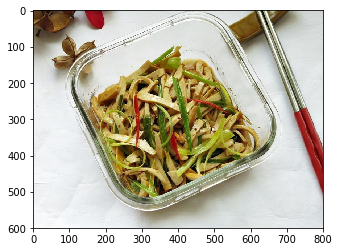

【圖片說明】 ../at081-group40/recipes_dataset/images/1d39b4b33a59fc47.jpg
  [椒麻豆乾]眷村口味涼拌菜 



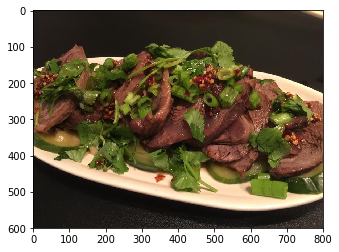

【圖片說明】 ../at081-group40/recipes_dataset/images/7d109832043a81a5.jpg
  壓力鍋快速《滷牛腱》眷村小菜 



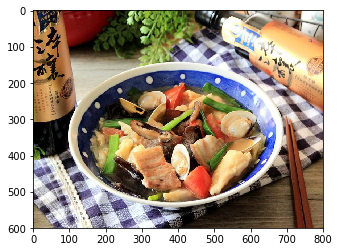

【圖片說明】 ../at081-group40/recipes_dataset/images/a0795a8d4df2841e.jpg
  眷村奶奶的麵疙瘩【淬釀阿嬤的手路菜】 



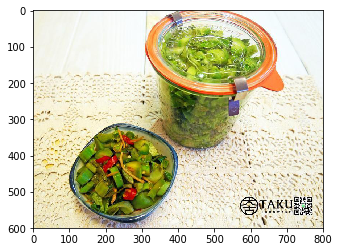

【圖片說明】 ../at081-group40/recipes_dataset/images/edfc349b06639eb1.jpg
  眷村開胃小菜 - 衝菜 



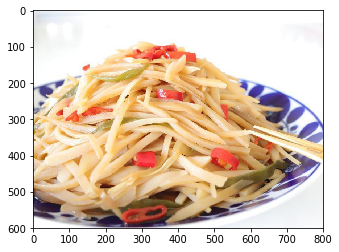

【圖片說明】 ../at081-group40/recipes_dataset/images/17e926a5dd071dea.jpg
  道地眷村味-醋溜土豆絲(馬鈴薯) 



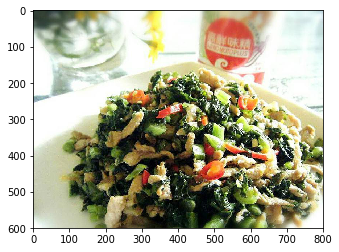

【圖片說明】 ../at081-group40/recipes_dataset/images/e8e4ed914f7bafba.jpg
  眷村味雪菜炒肉絲「味之素品牌」高鮮味精 



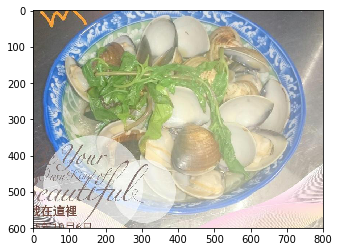

【圖片說明】 ../at081-group40/recipes_dataset/images/2870baa3b38662d2.jpg
  塔香蛤蜊 



[None, None, None, None, None, None, None]

In [13]:
[ show_image_rc(i) for i in range(1,8) ]

In [14]:
# show_image(idx=15, train=True)

#### Building CNN Model for Images

In [15]:
if Load_CNN:
    base_model = VGG16(weights='imagenet', include_top=True)     # Use VGG16 for base image model
    transfer_layer = base_model.get_layer('fc2')                 # Abstract the image features  
    image_model_transfer = Model( inputs  = base_model.input,    # Image Model for feature prediction
                                  outputs = transfer_layer.output)
    transfer_values_size = keras.backend.int_shape(transfer_layer.output)[1]
else: 
    transfer_values_size = 4096
print ('Image feature transfer value data shape:',transfer_values_size)

Image feature transfer value data shape: 4096


#### Predict the Transfer Values and Save to Disk

In [16]:
def process_images(data_dir, filenames, batch_size=32):         # (Image process module v02)
                                                                # 32 pics batch, add CV2 read EQ 
    num_images = len(filenames)                                 # Number of images to process.
    shape = (batch_size,) + img_size + (3,)                     # Prepare the image array
    image_batch = np.zeros(shape=shape, dtype=np.float16)       # Default shape(32, 224, 224 ,3)
                                 
    shape = (num_images, transfer_values_size)                  # Preare for the transfer array
    transfer_values = np.zeros(shape=shape, dtype=np.float16)   # Default shape is (files, 4096)

    pbar = tqdm(total=num_images, position=1)
    
    start_index = 0                                             # Index for the filenames.
    while start_index < num_images:                             # Batch reading image files.
        #print_progress(count=start_index, max_count=num_images) # Print progress
        pbar.update(start_index)                                # End of this batch.
        end_index = min(start_index+batch_size, num_images)     # The last batch may have a 
        current_batch_size = end_index - start_index            #      different batch-size.
                                                                # Load all the images in batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            path = os.path.join(data_dir, filename)             # Path of the image file
            img = load_image(path, size=img_size)               # Load and resize the image.
            image_batch[i] = img                                # Image into NP array
            if CV2_read_img:                                    # CV2 read post regulization
                if VGG16_img_pp:
                    image_batch[i] = preprocess_input(image_batch[i])
                else:
                    image_batch[i] /= 255.0 
                    if RGB_EQ:                                  # RGB Mean value balancing 
                        image_batch[i] -= [0.485, 0.456, 0.406]
                        image_batch[i] /= [0.229, 0.224, 0.225] # [0.5496, 0.5376, 0.54]
                                                                # Predict feature from the image.                          
        transfer_values_batch = \
                    image_model_transfer.predict(image_batch[0:current_batch_size])
                                                                # Save the transfer values
        transfer_values[start_index:end_index] = \
                    transfer_values_batch[0:current_batch_size]
        start_index = end_index                                 # Set the index for next loop.
            
    print()                                                     # Print newline.
    return transfer_values

In [17]:
def image_preprocess(train=True):   # Image pre-process to cache file (Image Prepocess module V02)
    
    (tr_file, im_file, im_dir) = \
            ("transfer_values_train.pkl", f_names_train, cocoa.train_dir) if train \
       else ("transfer_values_val.pkl",   f_names_val,   cocoa.val_dir  )
    
    print ("Pre-processing {0} images in the {1} set..."
           .format( len(im_file), "training" if train else "validation"))

    transfer_values = cocoa.cache(cache_path=os.path.join(cocoa.cache_dir,tr_file),
                      fn=process_images, data_dir=im_dir, filenames=im_file)

    print("Data Shape:", transfer_values.shape, " Type:", transfer_values.dtype)   
    return transfer_values    

In [18]:
def image_preprocess_rc():   # Image pre-process to cache file (Image Prepocess module V02)
    
    (tr_file, im_file, im_dir) = \
            ("transfer_values_rc.pkl", [ m for m in RC_imgs ], recipe_image_dir)
    
    print ("Pre-processing {0} images in the recipe data-set...".format( len(im_file)))

    transfer_values = cocoa.cache(cache_path=os.path.join(cocoa.cache_dir,tr_file),
                      fn=process_images, data_dir=im_dir, filenames=im_file)

    print("Data Shape:", transfer_values.shape, " Type:", transfer_values.dtype)   
    return transfer_values  

In [19]:
%%time
if Recipe_DS:
    transfer_values_rc = image_preprocess_rc()

Pre-processing 73952 images in the recipe data-set...
- Data loaded from cache-file: cache_vgg16_p/transfer_values_rc.pkl
Data Shape: (73952, 4096)  Type: float16
CPU times: user 105 ms, sys: 543 ms, total: 648 ms
Wall time: 646 ms


In [20]:
%%time
if COCO_DS:
    transfer_values_train = image_preprocess()

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.34 µs


In [21]:
%%time
if COCO_DS:
    transfer_values_val = image_preprocess(train=False)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 8.58 µs


#### Caption Pre-processing

In [22]:
M_start = 'ssss '
M_end = ' eeee'


In [23]:
if Chinese_caption:                 # Chinese Captions Processing
    
    import jieba                    # Load Jieba libray for Chinese 
    import jieba.posseg as pseg     #    word segmentation
   
    # The helper function for Chinese word segmentation
    def jieba_tokenizer(text):  
        words = pseg.cut(text)
        return ' '.join([word for word, flag in words if flag != 'x'])  
    
    if Seg_CWords:  # Perform Chinese caption segmentation 
        if COCO_DS:
            print ('Applying Chinese word processing on COCO dataset...')
            C_caps = pd.read_csv('Ch_cap2.csv')  # Read the machine translated         

            # Directly apply the segmenatation function to the captions
            C_cap_cut = C_caps['Caption'].apply(jieba_tokenizer)
        
            # Save the segmented captions to the csv file 
            pd.DataFrame(C_cap_cut).to_csv(Chinese_caption_tmp, index = False)
               
            C_cap_cut = C_cap_cut.values              # Covert the format from DF to list 
        if Recipe_DS:
            print ('Applying Chinese word processing on Recipe dataset...')

#             RC_cap_cut = pd.DataFrame(RC_caps)[0].apply(jieba_tokenizer)
            RC_cap_cut = list(map(jieba_tokenizer,tqdm(pd.DataFrame(RC_caps)[0], position=0)))
            pd.DataFrame(RC_cap_cut).to_csv(recipe_caption_tmp, index = False)

    else:  # Load the pre-segented data
        if COCO_DS:
            C_cap_cut  = pd.read_csv(Chinese_caption_tmp).values  
        if Recipe_DS:
            RC_cap_cut = pd.read_csv(recipe_caption_tmp).values
        
    # Select and mark the start-end tokens
#     C_cap_marked = [ M_start + C + M_end for C in C_cap_cut]
    if COCO_DS:
        C_cap_marked = M_start + np.array(C_cap_cut)+ M_end
        C_cap_flat   = [ Caps[0] for Caps in C_cap_marked ]    # Flatten the captions array
    if Recipe_DS:
        RC_cap_marked = [M_start + C + M_end for C in RC_cap_cut]
        #RC_cap_marked = M_start + np.array(RC_cap_cut)+ M_end
        RC_cap_flat  = [ Caps[0] for Caps in RC_cap_marked ]
#         RC_cap_flat  = [ Caps[0] for Caps in RC_cap_marked ]
    
else:                                 # English Captions Processing

    # The helper function to select and mark the start-end tokens
    def mark_captions(captions_listlist):
        if Caption_pre_select:
            cp_marked = [[ M_start + np.random.choice(captions_list) + M_end]
                            for captions_list in captions_listlist]                
        else:
            cp_marked = [[ M_start + caption + M_end
                            for caption in captions_list]
                            for captions_list in captions_listlist]    
        return cp_marked
    
    Caption_pre_select = False if K_fold_caption else Caption_pre_select

    caps_train_marked = mark_captions(caps_train)

    # Flatten the captions array
    caps_train_flat = [caption                       
                         for captions_list in caps_train_marked
                         for caption in captions_list]

In [24]:
num_words = 10000

class TokenizerWrap(Tokenizer):
   
    def __init__(self, texts, num_words=None):
        Tokenizer.__init__(self, num_words=num_words)
        self.fit_on_texts(texts)
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))
    def token_to_word(self, token):
        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        words = [self.index_to_word[token]
                 for token in tokens if token != 0]
        text = " ".join(words)
        return text
    
    def captions_to_tokens(self, captions_listlist):
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        return tokens

In [25]:
np.array(RC_cap_cut)[:3]

array([['眷村 懷舊 搶 鍋 麵'],
       ['椒 麻豆 乾 眷村 口味 涼拌菜'],
       ['壓力 鍋 快速 牛腱 眷村 小菜']], dtype=object)

In [26]:
RC_cap_marked = [M_start + C + M_end for C in RC_cap_cut]

In [27]:
RC_cap_marked[:3]


[array(['ssss 眷村 懷舊 搶 鍋 麵 eeee'], dtype=object),
 array(['ssss 椒 麻豆 乾 眷村 口味 涼拌菜 eeee'], dtype=object),
 array(['ssss 壓力 鍋 快速 牛腱 眷村 小菜 eeee'], dtype=object)]

In [28]:
RC_cap_flat  = [ Caps[0] for Caps in RC_cap_marked ]

In [29]:
RC_cap_flat[:3]

['ssss 眷村 懷舊 搶 鍋 麵 eeee',
 'ssss 椒 麻豆 乾 眷村 口味 涼拌菜 eeee',
 'ssss 壓力 鍋 快速 牛腱 眷村 小菜 eeee']

In [30]:
%%time
    if COCO_DS:
        tk_text = caps_train_flat
    if Recipe_DS:
        tk_text = RC_cap_flat       
tokenizer = TokenizerWrap(texts=tk_text, num_words=num_words)

CPU times: user 1.27 s, sys: 3.57 ms, total: 1.28 s
Wall time: 1.28 s


In [31]:
# tokenizer.word_index['iphone'],
tokenizer.word_index['鹿'],  tokenizer.word_index['雞絲']

(2246, 288)

In [32]:
token_start = tokenizer.word_index[M_start.strip()]
token_end   = tokenizer.word_index[M_end.strip()]
token_start, token_end

(1, 2)

In [33]:
# C_cap_flat[:3],
RC_cap_flat[:3]

['ssss 眷村 懷舊 搶 鍋 麵 eeee',
 'ssss 椒 麻豆 乾 眷村 口味 涼拌菜 eeee',
 'ssss 壓力 鍋 快速 牛腱 眷村 小菜 eeee']

In [34]:
%%time
# tokens_train = tokenizer.captions_to_tokens([C_cap_flat])[0]
tokens_rc = tokenizer.captions_to_tokens([RC_cap_flat])[0]

CPU times: user 1.14 s, sys: 5.24 ms, total: 1.14 s
Wall time: 1.14 s


In [35]:
len(tokens_rc), 
# len(tokens_train)

(73952,)

In [36]:
tokens_rc[1688], RC_cap_marked[1688]

([1, 102, 84, 61, 62, 2], array(['ssss 培根 馬鈴薯 鹹 派 eeee'], dtype=object))

In [37]:
max([c for t in tokens_rc for c in t])
# min([len(t) for tt in tokens_train[:] for t in tt])
# [len(t) for t in tokens_train[:] if len(t) != 5]

9999

In [38]:
if COCO_DS:
    if K_fold_caption:
        C_idx = np.random.randint(num_images_train, size=num_images_train)
        K_fold_idx = 0

    # Pre-calculate the caption numbers for each image    
    L_tokens_train = [len(t) for t in tokens_train]

In [39]:
def get_random_caption_tokens(idx, kf_idx=0):      # Get the captions in the image of the index array
  
    result = [] 
    for i in idx:                        # Random select a caption if "pre-selection" is not enabled
        if Caption_pre_select:           #  Only 1 caption per image when
            j = 0                        #  using pre-select or Chinese captions
        else:
            l = L_tokens_train[i]
            if K_fold_caption:               # Assign the caption for K-fold
                j = ( C_idx[i] + kf_idx ) % l   # Shift fold by kf_idx
            else:
                j = np.random.choice(l)      # Random select caption

        tokens = tokens_train[i]          # Get the j'th caption of image i. 

        result.append(tokens)                # Add to the list
    return result

In [40]:
def batch_generator(batch_size):

    while True:        # List of random index for images in training-set.

        if K_fold_caption:
            global K_fold_idx
            K_fold_idx += 1
        idx = np.random.randint(num_images_train, size=batch_size)  # Randan index for batch samples 
        transfer_values = transfer_values_train[idx]                # Get the transfer-values 
        if K_fold_caption:
            tokens = get_random_caption_tokens(idx, K_fold_idx)     # Get the random selected caption 
        else:                                                       #      of the selected image #.
            tokens = get_random_caption_tokens(idx)
#         num_tokens = [len(t) for t in tokens]                     # Count the number of tokens in all sequences.
#         max_tokens = np.max(num_tokens)                           # Max number of tokens.
        tokens_padded = pad_sequences(tokens,                       # Padding the token
                        maxlen=64, #max_tokens,                     #     into the same length.
                        padding='post', truncating='post')
        
        decoder_input_data = tokens_padded[:, 0:-1]                 # Arrange the token sequence 
        decoder_output_data = tokens_padded[:, 1:]                  # mapping 1-step shiftted.

        x_data = { 'decoder_input'        : decoder_input_data,     # Dict for the input-data.
                   'transfer_values_input': transfer_values     }
        y_data = { 'decoder_output'       : decoder_output_data }   # Dict for the output-data.
        
        yield (x_data, y_data)

In [41]:
def batch_generator_rc(batch_size):   # Recipe Data generator

    while True:        # List of random index for images in training-set.

        idx = np.random.randint(num_images_rc, size=batch_size)  # Randan index for batch samples 
        transfer_values = transfer_values_rc[idx]                # Get the transfer-values                                                      #      of the selected image #.
        tokens = []
        for i in idx:                        # Random select a caption if "pre-selection" is not enabled
            tokens.append(tokens_rc[i])        
#         num_tokens = [len(t) for t in tokens]                     # Count the number of tokens in all sequences.
#         max_tokens = np.max(num_tokens)                           # Max number of tokens.
        tokens_padded = pad_sequences(tokens,                       # Padding the token
                        maxlen=32, #64, #max_tokens,                     #     into the same length.
                        padding='post', truncating='post')
        
        decoder_input_data = tokens_padded[:, 0:-1]                 # Arrange the token sequence 
        decoder_output_data = tokens_padded[:, 1:]                  # mapping 1-step shiftted.

        x_data = { 'decoder_input'        : decoder_input_data,     # Dict for the input-data.
                   'transfer_values_input': transfer_values     }
        y_data = { 'decoder_output'       : decoder_output_data }   # Dict for the output-data.
        
        yield (x_data, y_data)

In [42]:
len(transfer_values_rc)

73952

In [43]:
tokens_rc[1]

[1, 306, 5451, 25, 1811, 262, 1011, 2]

In [44]:
if COCO_DS:
    generator1 = batch_generator(batch_size=RNN_batch_size)
    num_captions_train = [len(captions) for captions in caps_train]
    total_num_captions_train = np.sum(num_captions_train)
    steps_per_epoch = int(total_num_captions_train / RNN_batch_size)
    print ('Batch size: ',RNN_batch_size,'  Steps per epoch: ',steps_per_epoch)

In [45]:
if Recipe_DS:
    generator2 = batch_generator_rc(batch_size=RNN_batch_size)
    steps_per_epoch_rc = int(num_images_rc / RNN_batch_size) *5
    print ('Batch size: ',RNN_batch_size,'  Steps per epoch: ',steps_per_epoch_rc)

Batch size:  1024   Steps per epoch:  360


In [46]:
# Check the ouput of the generator
batch = next(generator2)
batch_x = batch[0]
batch_y = batch[1]
batch_x['transfer_values_input'][0], batch_x['decoder_input'][3], batch_y['decoder_output'][2]

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float16),
 array([   1, 2849,  609,    5,   53,   34,    2,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32),
 array([ 172, 1123,  344,  705,  551,    2,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32))

#### GloVe Embedding Layer

In [47]:
if Glove_enable:                        # Glove Embedding (Glove Embedding module v01)
    from keras.initializers import Constant
    
    Glove_dir = 'glove/glove.6B.100d.txt'
    Max_sequence_length = 128
    Embedding_DIM = 100
    embeddings_index = {}
    
    with open(Glove_dir) as f:                     # Loading the word vector
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print('Found %s word vectors.' % len(embeddings_index))
                             
    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((num_words, Embedding_DIM))

    for word, i in word_index.items():
        if i > num_words -1:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:            # index=0 if Words not found in embedding.
            embedding_matrix[i] = embedding_vector
                                    # load pre-trained word embeddings into an Embedding layer
    Glove_embd_layer = Embedding(input_dim=num_words,    
                                output_dim=128,
                                embeddings_initializer=
                                 tf.keras.initializers.Constant(embedding_matrix),
                                input_length=Max_sequence_length,
                                name="GloVe_Embedding",
                                trainable=False)     # Set trainable=False to fix the embeddings 

#### Building RNN Model for Caption Generator

In [48]:
# RNN Layers definition (RNN Layers Def v01)
state_size = 256 #if Hidden_NN_enable else 512
embedding_size = 128

transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')
decoder_transfer_map = Dense(state_size, activation='tanh',
                             name='decoder_transfer_map')
decoder_transfer_int = Dense(state_size, activation='tanh',
                             name='decoder_transfer_int')
decoder_input = Input(shape=(None, ), name='decoder_input')

word_embedding = Glove_embd_layer if Glove_enable else \
                 Embedding( input_dim=num_words,
                            output_dim=embedding_size,
                            name='decoder_embedding')

decoder_gru1 = GRU(state_size, name='decoder_gru1', return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2', return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3', return_sequences=True)
decoder_dense = Dense(num_words,activation='linear', name='decoder_output')

drop_out = lambda Layer : Dropout(0.3)(Layer) if RNN_dropout else Layer

In [49]:
def connect_decoder(transfer_values):       # Decoder model definintion (Decoder_model v02)
    # Note: v02 add Hidden layer NN, GloVe and RNN drop-out features
    # Peek architecture 3-layer RNN Mapping the transfer value to all 3 RNN as initial states
 
    initial_state = decoder_transfer_map(transfer_values)   # Image feature input form VGG16
    initial_state = Dropout(0.4)(initial_state)             # Dropout layer
    
    if Hidden_NN_enable:                                    # Adding a NN as the hidden layer
        initial_state = decoder_transfer_int(initial_state)
        initial_state = Dropout(0.4)(initial_state)         # Dropout layer
    
    net = decoder_input                                     # input caption form generator
    
    net = word_embedding(net)                               # Connect the embedding-layer.

    if Self_attention:                                      # Self Attention Model 
        att = TimeDistributed(Dense(1, activation='tanh'))(net)
        att = Flatten()(att)
        att = Activation('softmax')(att)
        att = RepeatVector(128)(att)
        att = Permute([2,1])(att)

        rep = multiply([net, att])
        rep = Lambda(lambda xin: K.sum(xin, axis=-1, keepdims=True))(rep)

        dec = concatenate([net, rep], axis=-1)
        dec = BatchNormalization(-1)(dec)

#         if RNN_dropout:
#             dec = Dropout(0.2)(dec)                             # RNN for caption generation
    dec = drop_out(dec)    
    dec = decoder_gru1(dec, initial_state=initial_state)    # Feature connect all the GRU layers.
#         if RNN_dropout: 
#             dec = Dropout(0.2)(dec)
    dec = drop_out(dec) 
    dec = decoder_gru2(dec, initial_state=initial_state)
#         if RNN_dropout: 
#             dec = Dropout(0.2)(dec)
    dec = drop_out(dec) 
    dec = decoder_gru3(dec, initial_state=initial_state)
      
                 
    if Decoder_NN:
        decoder_output = add([initial_state, net])
        decoder_output = Dense(256, activation='relu')(net)
        decoder_output = Dropout(0.2)(decoder_output)
        decoder_output = decoder_dense(decoder_output)
    else:
        decoder_output = decoder_dense(dec)
    
#     decoder_output = decoder_dense(net)     # Connect to final Dense for decoding words
    return decoder_output

In [50]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)
decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

In [51]:
def sparse_cross_entropy(y_true, y_pred):           # Define the customer lost function
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)
    loss_mean = tf.reduce_mean(loss)
    return loss_mean

In [52]:
optimizer = RMSprop(lr=1e-3)
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

decoder_model.compile(optimizer=optimizer,
                      loss=sparse_cross_entropy,
#                       loss='sparse_categorical_crossentropy',
                      target_tensors=[decoder_target])

Using TensorFlow backend.


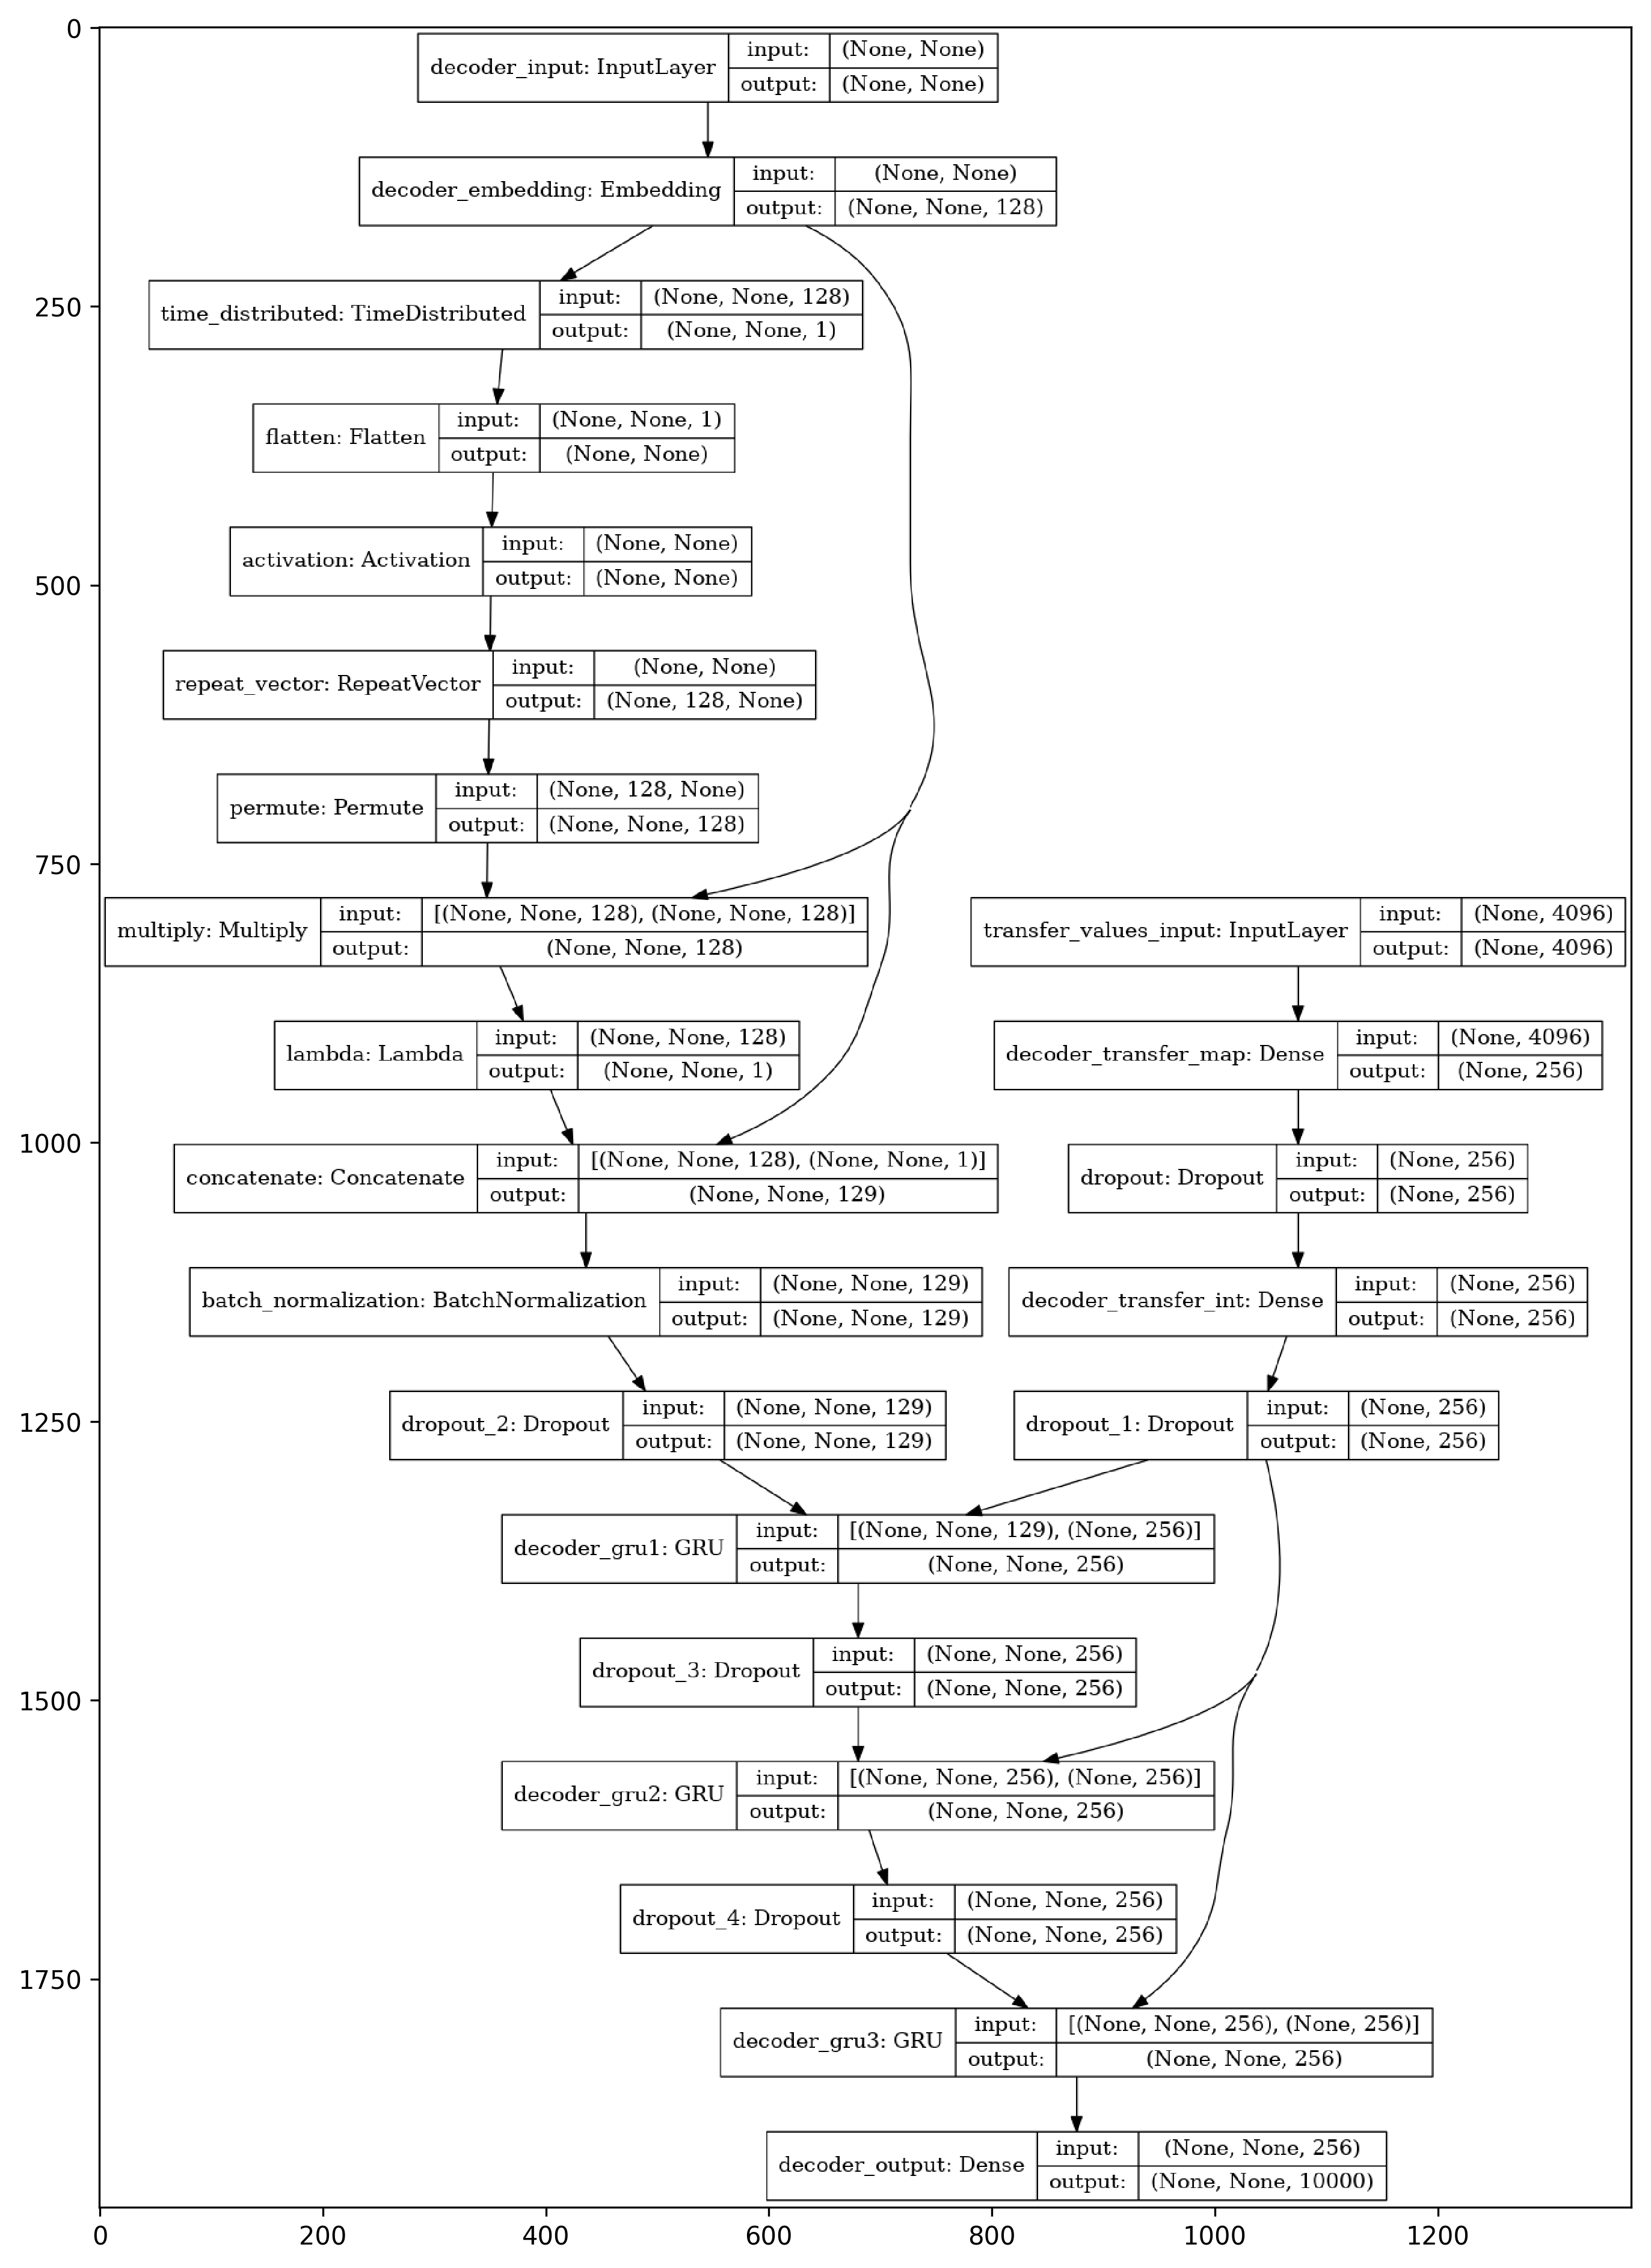

In [53]:
# RNN Model Graph output (RNN model graphic module  v01)
# ! pip install pydot
if 1:# Plot_RNN_model:
    from keras.utils import plot_model
    plot_model(decoder_model, show_shapes=True, to_file='decoder_model.png')
    plt.figure(figsize=(24,16),frameon=False, dpi=300)
    plt.imshow(cv2.imread('decoder_model.png'))
    plt.show()

In [54]:
# Call-back function (Call-back module  v01)
callback_CP = ModelCheckpoint( filepath=check_point_file, verbose=1, save_weights_only=True)
callback_TB = TensorBoard( log_dir='./log/', histogram_freq=0, write_graph=False)
callbacks = [callback_CP, callback_TB]

#### Model Training

In [55]:
%%time
# RNN_Training  (RNN training control module  v02)
if RNN_cont_train or not RNN_training:                        # Load the pre-trained model
    try:                                                      # from the check point.
        decoder_model.load_weights(check_point_file)
    except Exception as error:
        print("Error loading checkpoint.")
        print(error)        

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10.3 µs


In [56]:
%%time
if RNN_training or RNN_cont_train:                                              # RNN Training loop
    if COCO_DS:
        decoder_model.fit_generator(generator=generator1,
                            steps_per_epoch=steps_per_epoch,
                            epochs=RNN_epochs,
                            callbacks=callbacks) 
 

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


In [90]:
%%time
if RNN_training or RNN_cont_train:                                              # RNN Training loop
    if Recipe_DS:
        decoder_model.fit_generator(generator=generator2,
                                steps_per_epoch=steps_per_epoch_rc,
                                epochs=4,#RNN_epochs,
                                callbacks=callbacks)       

Epoch 1/4
359/360 [============================>.] - ETA: 0s - loss: 0.4141
Epoch 00001: saving model to checkpoint003c.keras
360/360 [==============================] - 86s 239ms/step - loss: 0.4141
Epoch 2/4
359/360 [============================>.] - ETA: 0s - loss: 0.4107
Epoch 00002: saving model to checkpoint003c.keras
360/360 [==============================] - 86s 240ms/step - loss: 0.4107
Epoch 3/4
359/360 [============================>.] - ETA: 0s - loss: 0.4079
Epoch 00003: saving model to checkpoint003c.keras
360/360 [==============================] - 86s 240ms/step - loss: 0.4079
Epoch 4/4
359/360 [============================>.] - ETA: 0s - loss: 0.4052
Epoch 00004: saving model to checkpoint003c.keras
360/360 [==============================] - 86s 240ms/step - loss: 0.4053
CPU times: user 5min 1s, sys: 39.9 s, total: 5min 41s
Wall time: 5min 45s


#### Caption Generating

In [83]:
if Bleu_Score:                 # Import libray for Bleu
    from nltk.translate.bleu_score import sentence_bleu
    from nltk.translate.bleu_score import corpus_bleu

In [84]:
Translate = False if Chinese_caption else Tranlate

if Translate:    # Import libray for Google Translation
    # ! pip install googletrans
    from googletrans import Translator
    translator = Translator()

In [85]:
def generate_caption(image_path, max_tokens=32):               # (Caption gen module   v01)

    image = load_image(image_path, size=img_size)              # Load and resize the image.
    image_batch = np.expand_dims(image, axis=0)                # Batch for 1 image
                                                               # Predit the image feature
    transfer_values = image_model_transfer.predict(image_batch)
    shape = (1, max_tokens)                                    # Prepare 2D array for decoder
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)
    token_int = token_start                                    # Start with 'ssss '.
    output_text = ''                                           # Initialize an empty output-text.
    count_tokens = 0                                           # Init number of tokens processed.
                                                    
    while token_int != token_end and count_tokens < max_tokens:
        decoder_input_data[0, count_tokens] = token_int        # Input last sampled token until 
                                                               #     ' eeee' or max # of tokens.
        x_data = {'transfer_values_input': transfer_values,    # Prepare for input data into set
                  'decoder_input': decoder_input_data   }  
        
        decoder_output = decoder_model.predict(x_data)         # predicted output.
        token_onehot = decoder_output[0, count_tokens, :]      # Get the last predicted token array.
        token_int = np.argmax(token_onehot)                    # Convert to an integer-token.
        sampled_word = tokenizer.token_to_word(token_int)      # Lookup the word corresponding to this integer-token.
        if Chinese_caption:
            output_text += sampled_word
        else:
            output_text += " " + sampled_word                  # Append the word to the output-text.
        count_tokens += 1                                      # Increment the token-counter.

    if Chinese_caption: 
        output_text = output_text.rstrip( M_end)
    else:    
        output_text = output_text.replace( M_end,'.').lstrip().rstrip().capitalize()

    output_tokens = decoder_input_data[0]                      # Sequence of tokens output by the decoder.

    plt.imshow(image)                                          # Plot the image.
    plt.show()
    print("【圖片說明】") if Chinese_caption else print("Predicted caption:")
    print(' ', output_text)                                # Print the predicted caption.
    if Translate:
        print(' ', translator.translate(output_text, dest='zh-TW').text) 
    print()
    
    return list(output_text)   

In [86]:
def generate_caption_coco(idx, train=False):                   # (Coco caption gen module   v03)
    if not COCO_DS:
        return "COCO_DS not enabled."
    img_f_names, img_captions = lookup_dataset(idx, train)     # Get image location and captions
    gen_caption = generate_caption(image_path=img_f_names)                   # To generate a caption of the image.
    print("Default captions:")                                 # Print the default captions 
    true_captions = list()
    for caption in img_captions:                               #            from the data-set.
        print(' ',caption)
        if Translate:
            print(' ', translator.translate(caption, dest='zh-TW').text) 
        true_captions.append(list(caption))
        
    if Bleu_Score: # Sentence BLEU evaluate
        print('Individual 1-gram: %f' % sentence_bleu(true_captions, gen_caption, weights=(1, 0, 0, 0)))
        print('Individual 2-gram: %f' % sentence_bleu(true_captions, gen_caption, weights=(0, 1, 0, 0)))
        print('Individual 3-gram: %f' % sentence_bleu(true_captions, gen_caption, weights=(0, 0, 1, 0)))
        print('Individual 4-gram: %f' % sentence_bleu(true_captions, gen_caption, weights=(0, 0, 0, 1)))

        #Corpus BLEU evaluate
        reference = [true_captions]
        candidates = [gen_caption]
        print('BLEU-1: %f' % corpus_bleu(reference, candidates, weights=(1.0, 0, 0, 0)))
        print('BLEU-2: %f' % corpus_bleu(reference, candidates, weights=(0.5, 0.5, 0, 0)))
        print('BLEU-3: %f' % corpus_bleu(reference, candidates, weights=(0.3, 0.3, 0.3, 0)))
        print('BLEU-4: %f' % corpus_bleu(reference, candidates, weights=(0.25, 0.25, 0.25, 0.25)))


In [62]:
generate_caption_coco(idx=165, train=True)

'COCO_DS not enabled.'

In [63]:
generate_caption_coco(idx=1, train=True)

'COCO_DS not enabled.'

In [64]:
generate_caption_coco(idx=128, train=False)

'COCO_DS not enabled.'

In [65]:
generate_caption_coco(idx=12555, train=True)

'COCO_DS not enabled.'

In [78]:
for l in range (10):
    generate_caption_coco(idx=559 + l, train=False)

In [79]:
for l in range (10):
    generate_caption_coco(idx=3345 + l, train=False)

In [87]:
def generate_caption_rc(idx):                   # (Recipe caption gen module   v02)
    if not Recipe_DS:
        return "Recipe DS not enabled."
    img_f_names = os.path.join(recipe_image_dir, RC_imgs[idx])
    gen_caption = generate_caption(image_path=img_f_names)     # To generate a caption of the image.
    print("【原始說明】")                                 # Print the default captions 
    print(' ', RC_caps[idx])

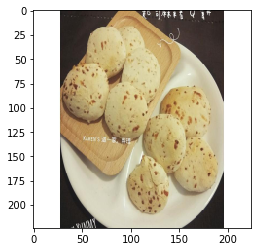

【圖片說明】
  咖啡曲奇

【原始說明】
  起司麻糬QQ麵包


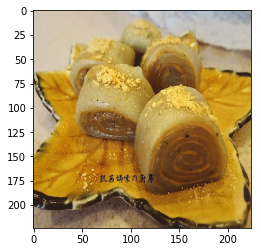

【圖片說明】
  抹茶生乳

【原始說明】
  よもぎ麻糬🎶


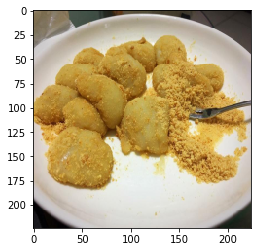

【圖片說明】
  紫米

【原始說明】
  自己做麻糬～超簡單不失敗


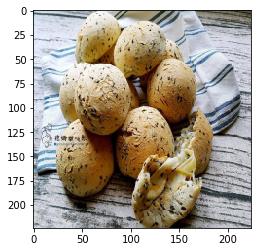

【圖片說明】
  紅豆饅頭

【原始說明】
  韓國麻糬起士麵包


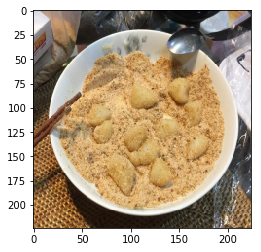

【圖片說明】
  全素

【原始說明】
  客家麻糬


In [91]:
img_sn = 3588
for i in range(5):
    generate_caption_rc(img_sn + i)

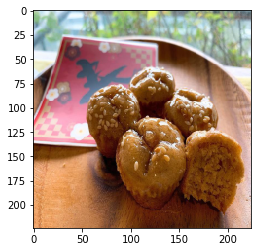

【圖片說明】
  曲奇

【原始說明】
  鬆餅機黑糖發糕


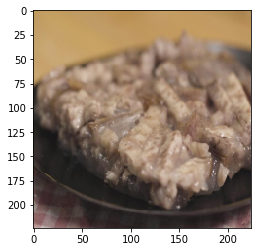

【圖片說明】
  素珍珠丸子

【原始說明】
  芋頭籤粿


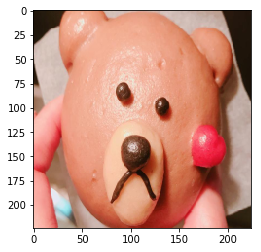

【圖片說明】
  龍貓饅頭

【原始說明】
  熊大饅頭


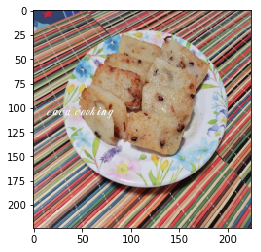

【圖片說明】
  免烤免烤乳酪蛋糕

【原始說明】
  台式蘿蔔糕


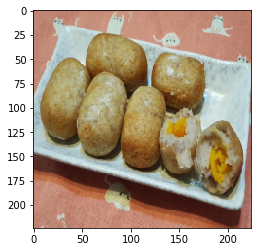

【圖片說明】
  芝麻饅頭

【原始說明】
  蛋黃芋棗～台灣古早味甜點


In [92]:
img_sn = 45367
for i in range(5):
    generate_caption_rc(img_sn + i)

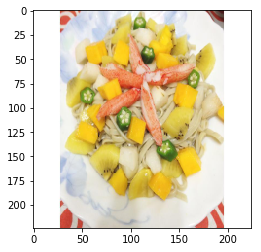

【圖片說明】
  日式涼麵

【原始說明】
  戀夏爽口料理:芒果優格水果涼麵


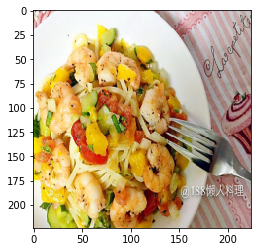

【圖片說明】
  涼拌苦瓜

【原始說明】
  芒果鮮蝦義大利冷麵


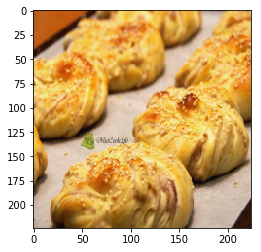

【圖片說明】
  芋頭西米露

【原始說明】
  原味香芋麵包


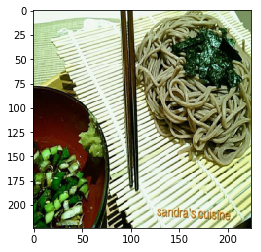

【圖片說明】
  日式涼麵

【原始說明】
  和風芥末蕎麥冷麵


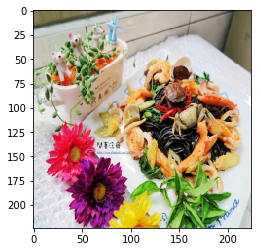

【圖片說明】
  泰式涼拌

【原始說明】
  塔香海鮮墨魚麵


In [71]:
img_sn = 53588
for i in range(5):
    generate_caption_rc(img_sn + i)

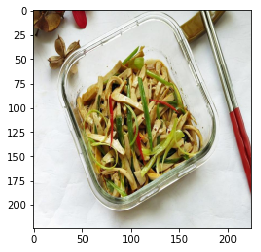

【圖片說明】
  涼拌木耳

【原始說明】
  [椒麻豆乾]眷村口味涼拌菜


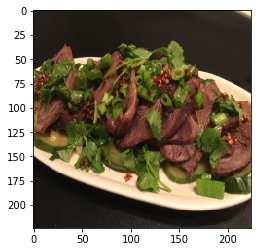

【圖片說明】
  涼拌苦瓜

【原始說明】
  壓力鍋快速《滷牛腱》眷村小菜


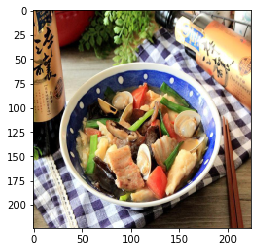

【圖片說明】
  泰式酸辣

【原始說明】
  眷村奶奶的麵疙瘩【淬釀阿嬤的手路菜】


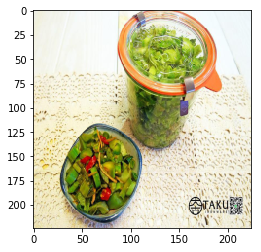

【圖片說明】
  常備菜

【原始說明】
  眷村開胃小菜 - 衝菜


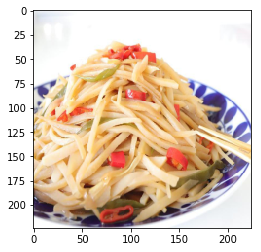

【圖片說明】
  涼拌菠菜

【原始說明】
  道地眷村味-醋溜土豆絲(馬鈴薯)


In [72]:
img_sn = 1
for i in range(5):
    generate_caption_rc(img_sn + i)

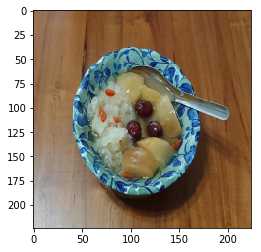

【圖片說明】
  素食大阪

【原始說明】
  港甜湯-蘋果雪耳糖水


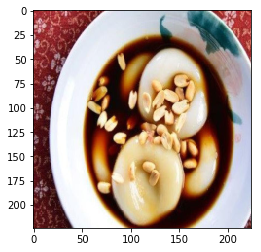

【圖片說明】
  日式茶碗蒸

【原始說明】
  轆湯粢（甜的大粄圓或牛汶水）《做粄粿》 


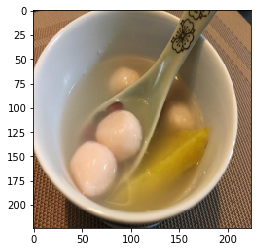

【圖片說明】
  冰糖蓮子

【原始說明】
  薑汁地瓜甜湯圓


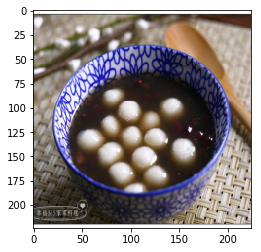

【圖片說明】
  紅豆湯

【原始說明】
  紅豆湯圓


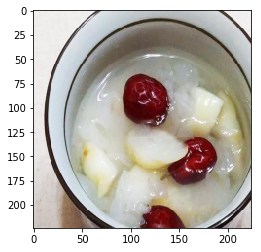

【圖片說明】
  冰糖蓮子

【原始說明】
  【厚生廚房】葛鬱金養顏甜湯


In [73]:
img_sn = 23456
for i in range(5):
    generate_caption_rc(img_sn + i)

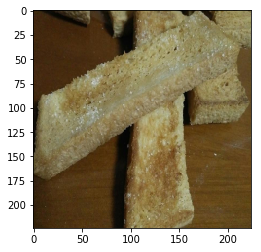

【圖片說明】
  吐司條

【原始說明】
  吐司條


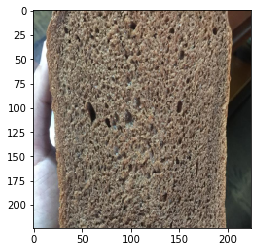

【圖片說明】
  蛋糕

【原始說明】
  軟Q巧克力吐司


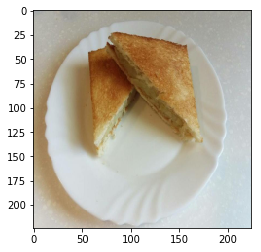

【圖片說明】
  涼拌秋葵全素

【原始說明】
  地瓜泥夾心吐司(2018 R203)


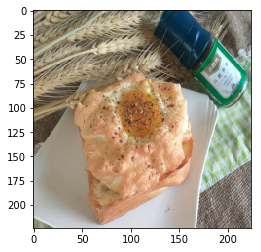

【圖片說明】
  免烤乳酪蛋糕免烤

【原始說明】
  十分鐘上菜─雲朵太陽土司早餐


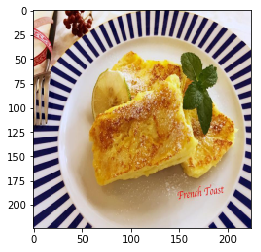

【圖片說明】
  客家蘿蔔糕湯

【原始說明】
  優格法式吐司


In [89]:
img_sn = 65432
for i in range(5):
    generate_caption_rc(img_sn + i)